In [ ]:
import os, json, glob
import warnings
warnings.filterwarnings("ignore")

from typing import List, Literal
from typing_extensions import TypedDict

import os
from typing import List, Dict, Any, Optional
from dotenv import load_dotenv
from pydantic import BaseModel, Field

# LangChain 최신 버전 임포트
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.chat_models import ChatOllama
from langchain_community.vectorstores import Chroma 
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.documents import Document

# LangGraph 관련 임포트
from langgraph.graph import StateGraph, START, END
from langchain_community.document_loaders import JSONLoader
from langchain_community.document_loaders import DirectoryLoader, JSONLoader
from langchain_core.documents import Document

load_dotenv()

if not os.environ.get('OPENAI_API_KEY'):
    raise ValueError('key check....')

# 데이터 로드
path = r'C:\Users\pc\Downloads\59.반려견 성장 및 질병 관련 말뭉치 데이터\59.반려견 성장 및 질병 관련 말뭉치 데이터\3.개방데이터\1.데이터\Training\01.원천데이터\TS_말뭉치데이터_내과'

docs = []

for file_path in glob.glob(os.path.join(path, "**", "*.json"), recursive=True):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    title = data.get("title", "") or ""
    disease = data.get("disease", "") or ""

    # title + disease를 page_content로 합쳐줌
    if title and disease:
        page_content = f"{title}\n\n{disease}"
    else:
        page_content = title or disease  # 하나만 있어도 그걸로

    meta = {
        "title": title,
        "author": data.get("author", None),
        "publisher": data.get("publisher", None),
        "department": data.get("department", None),
        "source_type": "AIHUB_data",
    }

    docs.append(Document(page_content=page_content, metadata=meta))

print(f"총 {len(docs)}개 문서 로드 완료")
print(docs[0].page_content[:300])
print(docs[0].metadata)

#텍스트 분할 

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300, chunk_overlap = 50
)
doc_splits = text_splitter.split_documents(docs)


#임베딩 및 VectorDB

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name='crag_collection',
    embedding=OpenAIEmbeddings(model='text-embedding-3-small'),
    persist_directory='./chroma_db' # 저장 경로
)


In [ ]:
# 동물병원 데이터 로드

hos_path = r"C:\Users\pc\Desktop\VSC\openai\LLM\3차 프로젝트\data\서울시 동물병원 인허가 정보.json"

with open(hos_path, encoding="utf-8") as f:
    raw = json.load(f)

records = raw["DATA"]

vet_docs = []
for row in records:
    status = row.get("trdstatenm", "")   # 영업상태

    # 1) 영업중인 병원만 포함
    if status and "영업" not in status:
        continue  # for문 안에서 정상적으로 작동

    # 2) 이제 나머지 필드 처리
    name = row.get("bplcnm", "") # 이름
    road_addr = row.get("rdnwhladdr", "") # 도로명 주소
    lot_addr = row.get("sitewhladdr", "") # 지번
    tel = row.get("sitetel", "") # 전화번호
    detail_status = row.get("dtlstatenm", "") #상세 영업 상태 

    content = f"""
    병원명: {name}
    도로명 주소: {road_addr}
    지번 주소: {lot_addr}
    전화번호: {tel if tel else "정보 없음"}
    영업상태: {status} ({detail_status})
    """.strip()

    doc = Document(
        page_content=content,
        metadata={
            "name": name,
            "road_addr": road_addr,
            "lot_addr": lot_addr,
            "tel": tel,
            "status": status,
            "detail_status": detail_status,
            "x": row.get("x"),
            "y": row.get("y"),
        },
    )
    vet_docs.append(doc)

print("총 병원 수:", len(vet_docs))

총 병원 수: 964


### 벡터DB 저장

데이터별로 DB 각각 구축

왜 서로 다른 목적 데이터는 DB를 분리하는 게 좋은가?

1) 검색 노이즈 방지할 수 있음

        같은 벡터DB 안에 여러 컬렉션이 있더라도, 개발자가 컬렉션을 잘못 지정하거나 retriever 설정이 꼬이면 의도치 않은 컬렉션이 검색될 위험이 있음

        EX) <병원 검색>인데 질병 설명 문서가 나옴

2) 확장성/버전 관리 쉬움

3) Agent에서 라우팅 로직 깔끔

    <진료 상담> → health_retriever
    <병원 검색> → hospital_retriever

In [3]:
#내과 데이터는 저장해둔 벡터DB 불러오기

embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

vectorstore = Chroma(
persist_directory="./chroma_db",
collection_name="pet_health_knowledge",
embedding_function=embeddings
)



C:\Users\pc\AppData\Local\Temp\ipykernel_19508\2076788975.py:5: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [4]:
# 병원 데이터는 벡터DB 생성

# 1. 임베딩 모델 정의
vet_embedding = OpenAIEmbeddings(model="text-embedding-3-small")

# 2. 병원 전용 벡터스토어 생성
vet_vectorstore = Chroma.from_documents(
    documents=vet_docs,                
    embedding=vet_embedding,
    collection_name="vet_hospitals_1",  # 의료용이랑 겹치지 않게 다른 이름으로
    persist_directory="./vet_chroma_db" # 저장 경로
)



### 리트리버

In [5]:
# 내과 리트리버 생성
retriever = vectorstore.as_retriever(
    search_type="similarity", # default값 : similarity
    search_kwargs={'k':3})

In [6]:
# 병원 리트리버 생성
vet_retriever = vet_vectorstore.as_retriever(
    search_type="similarity", # default값 : similarity
    search_kwargs={"k": 3}  
)


### 질문 분류

In [7]:
#질문 분류 체인 생성

from typing import Literal

# 의도 스키마 정의
class RouteQuery(BaseModel):
    '''질문이 어떤 분야로 보내야 하는지 판단시키기 위해 입력 형식 강제'''
    route: Literal["medical", "vet_hospital", "general"]

router_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) #llm 정의
structured_router = router_llm.with_structured_output(RouteQuery) #llm이 RouteQuery에서 정의한 형식으로 출력할 수 있도록 함

route_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 사용자의 질문을 분류하는 라우터입니다.

질문을 아래 셋 중 하나로 분류하세요.

- "medical" : 반려동물의 증상, 질병, 치료, 약, 예방접종 등 '의학적/건강 상담' 관련 질문
- "vet_hospital" : 동물병원 위치, 위치 근처 병원 추천, 지도/주소 등 '병원 정보/위치' 관련 질문
- "general" : 위 두 가지에 해당하지 않는 일반적인 질문 (일반 지식, 일상 대화, 기타)

route 필드에 "medical" / "vet_hospital" / "general" 중 하나만 반환하세요.
"""),
    ("human", "질문: {question}")
])

# 질문 분류 체인 생성
# LCEL 체인
route_chain = route_prompt | structured_router


### 문서 관련성 평가를 위한 Grader 정의

In [8]:
from pydantic import BaseModel, Field

class GradeDocuments(BaseModel): 
    '''문서 관련성 평가 결과를 위한 pydantic 모델'''
    binary_score: str  = Field(description="문서가 질문과 관련이 있으면 'yes, 없으면 no")

'''''''''''''''''''''''''''''''''''''''''''''''''''
llm
=> 문서가 맞는지 LLM이 한 번 더 체크
'''''''''''''''''''''''''''''''''''''''''''''''''''
grader_llm = ChatOpenAI(model = 'gpt-4o-mini',temperature=0)
structured_grader =  grader_llm.with_structured_output(GradeDocuments) ##llm이 GradeDocument에서 정의한 형식으로 출력할 수 있도록 함 

#
#프롬프트 템플릿 정의
grade_prompt = ChatPromptTemplate.from_messages([
    ('system','''당신은 검색된 문서가 사용자의 질문에 답변하는데 관련이 있는지 평가하는 전문가 입니다.
     
     평가기준:
     - 문서가 질문의 키워드나 의미와 연관되어 있다면 '관련있음'으로 평가
     - 답변에 도움이 될 가능성이 조금이라도 있다면 '관련있음'
     - 와전히 무관한 내용이면 '관련없음'

     엄격하게 평가하지 말고, 약간의 연관성이라도 있으면 'yes'를 반환하세요     
'''),
('human','''질문:{question}
 
 문서내용:
 {document}

 이 문서가 질문과 관련이 있습니까? 'yes' 또는 'no'로만 답하세요
 ''')
])

#프롬포트와 llm 연결
#문서 평가기 document_grader 체인 정의
document_grader = grade_prompt | structured_grader

### 동물병원 검색 체인



In [9]:
prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            """
너는 '서울시 동물병원 인허가 정보'를 기반으로 동물병원 정보를 안내하는 어시스턴트이다.

[규칙]
- 아래에 제공된 병원 목록(Context) 안의 정보만 사용해서 답변한다.
- 병원명, 주소(도로명 주소 위주), 전화번호, 영업 상태를 중심으로 정리해서 알려준다.
- 사용자의 질문(지역, 조건 등)에 최대한 맞는 병원만 최대 3개까지 골라서 번호를 붙여 제안한다.
- 조건에 정확히 맞는 병원이 없으면, 그 사실을 먼저 말하고 가장 비슷한 병원을 추천한다.
- 데이터에 없는 병원이나 서울시 외 지역에 대해서는 지어내지 않고 "데이터에 없음"이라고 말한다.
"""
        ),
        (
            "human",
            """
사용자 질문:
{question} 다음은 검색된 병원 목록(Context)입니다:

{context} 위 병원 목록 중에서, 사용자의 요구에 가장 잘 맞는 병원들을 최대 3개까지 골라
1번, 2번, 3번 형식으로 정리해서 알려주세요.
"""
        ),
    ])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


#동물병원 체인 정의
hospital_chain = prompt | llm | StrOutputParser()



### 답변 생성 체인

In [10]:
# 답변 생성 체인

prompt = ChatPromptTemplate.from_messages([
        ("system", """당신은 반려견(개) 질병·증상에 대해 정보를 제공하는 AI 어시스턴트입니다. 
당신의 역할은 수의사를 대신해 진단·처방을 내리는 것이 아니라, 제공된 문맥(Context)을 바탕으로 사용자가 상황을 이해하고 적절히 동물병원을 방문할 수 있도록 돕는 것입니다.

[역할/한계]
- 당신은 수의사가 아니며, 최종 진단이나 약물·검사 처방을 내리지 않습니다.
- 제공된 문맥 범위 안에서, 가능한 원인과 병명, 일반적인 주의사항을 설명하는 정보 제공자입니다.
- 증상이 심각하거나 응급이 의심되면 반드시 동물병원 방문을 강력하게 권고해야 합니다.

[응답 규칙]
1. 반드시 "제공된 문맥(Context)" 안의 정보만 우선적으로 사용하세요. 
   - 문맥에 없는 질병명, 약 이름, 용량, 시술·검사 내용은 지어내지 마세요.
   - 확실하지 않은 내용은 "추측"임을 분명히 밝히고, 병원 방문을 권고하세요.
2. 사용자의 질문 속 반려견 상태를 먼저 정리한 뒤, 생각해 볼 수 있는 원인들을 
   "가능성" 수준으로 설명하세요. 구체적인 병명이 있을 경우 해당 병명이 의심됩니다로 이야기 하세요.
3. 아래와 같은 단어·상황이 질문에 포함되면, 응답 맨 앞에 응급 안내 문장을 한 줄로 넣으세요.
   - '숨을 잘 못 쉬어요', '호흡이 가빠요', '쓰러졌어요', '경련', '발작', 
     '피를 토해요', '혈변', '혈뇨',
     '의식을 잃었어요', '중독', '강한 통증' 등
   예시: 
   "현재 서술된 증상은 응급 상황일 수 있으므로, 가능한 한 빨리(최대 수 시간 이내) 가까운 동물병원을 내원하시길 권고드립니다."
4. 답변 구조를 다음 형식에 맞춰 한국어로 작성하세요.
   1) 요약: 사용자의 질문 속 반려견 상태를 2~3문장으로 정리  
   2) 생각해 볼 수 있는 원인들: 문맥(Context)에 근거하여 가능한 원인들을 항목으로 정리  
   3) 집에서 즉시 해볼 수 있는 안전한 관리 방법: 수분 공급, 관찰 포인트 등 (위험하거나 전문 처치가 필요한 내용은 병원 의뢰)  
   4) 동물병원 방문 필요성:  
      - 언제까지 병원에 가야 하는지 (즉시 / 오늘 중 / 1~2일 내 등)  
      - 어떤 증상이 동반되면 바로 응급실을 권장해야 하는지
5. 사람(인간) 의학 정보가 섞여 있는 문맥일 경우:
   - 반려견/반려동물과 직접적으로 연결할 수 있는 일반적인 개념(예: 설사 시 탈수 위험, 구토 시 위장 자극 등)만 조심스럽게 활용하세요.
   - 문맥이 사람 내과 정보 위주라 반려견에 그대로 적용하기 어렵다면, 
     "현재 제공된 자료는 주로 사람 의학 정보라서, 반려견에게 1:1로 적용하기에는 한계가 있습니다."라는 내용을 포함해 주세요.
6. 전체 톤은:
   - 공손한 존댓말
   - 보호자를 안심시키되, 필요한 부분에서는 분명하게 병원 방문을 권고하는 상담 톤
"""),
        ("human",
"""
문맥(Context):
{context}

사용자 질문(반려견 상태 설명):
{question}

위 문맥(Context)을 벗어나지 않는 선에서,
반려견 질병·증상 상담 규칙에 따라 보호자가 이해하기 쉽도록
아래 형식을 지켜 답변해 주세요:

1) 요약: 보호자가 작성한 반려견 상태를 2~3문장으로 정리  
2) 가능한 원인들: 문맥에 기반하여 구체적으로 설명  
3) 집에서 즉시 해볼 수 있는 안전한 관리 방법  
4) 언제 병원에 가야 하는지, 어떤 증상이 동반되면 응급인지 명확하게 안내  

*추측은 하지 말고, 문맥(Context)에 없는 정보는 사용하지 마세요.
답변:""")
    ])

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


# 문서 포맷팅
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )

# 체인 생성
rag_chain = prompt | llm | StrOutputParser()


# 체인 실행 및 결과 출력
# generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
# print(generation)

### 웹 검색 도구

In [11]:
# 웹 검색 도구 
from langchain_community.tools.tavily_search import TavilySearchResults

web_search = TavilySearchResults(k=3) #최대 검색 결과 3개

# web_results = web_search.invoke({"query": question}) # doc 형태로 나옴 

C:\Users\pc\AppData\Local\Temp\ipykernel_19508\1233154321.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search = TavilySearchResults(k=3) #최대 검색 결과 3개


### 상태 정의

In [12]:
'''
RAG 상태 정의 
'''
class CGRAState(TypedDict):
    question : str
    documents : List[Document] # 검색된 문서
    filtered_documents: List[Document] # 검색된 문서 중, 관련성 평가를 통과한 문서
    web_search_needed : str   # 웹검색 여부(yes/no)
    context : str
    answer : str
    grade_results : List[str]   #각 문서의 평가 결과
    route : str

### 노드 정의


In [13]:
# 질문 의도 분류 노드
def route_node(state: CGRAState) -> dict:
    question = state["question"]
    result = route_chain.invoke({"question": question})
    route = result.route
    print(f"\n   [ROUTE] 라우팅 결과: {route}")
    return {"route": route}


In [14]:
# 동물병원 검색 노드
def vet_hospital_node(state: CGRAState) -> dict:
    print("\n   [VET_HOSPITAL 노드] 동물병원 관련 질문 처리 중...")

    question = state["question"]

    # 1. 동물병원 벡터스토어에서 관련 병원 검색
    # vet_retriever는 미리 만들어둔 전역 객체라고 가정 (예: vet_vectorstore.as_retriever(...))
    hospital_docs = vet_retriever.invoke(question)

    # 검색 결과가 없을 수도 있음
    if not hospital_docs:
        print("   검색된 병원이 없습니다.")
        answer = (
            "질문과 관련된 동물병원을 찾지 못했습니다.\n"
            "조금 더 구체적으로 지역(구/동)이나 원하는 조건을 알려주시면 다시 찾아볼게요."
        )
        return {
            "documents": [],
            "context": "",
            "answer": answer,
        }

    # 2. 찾은 병원 정보들을 하나의 컨텍스트로 결합
    context = "\n\n---\n\n".join([doc.page_content for doc in hospital_docs])

    # 3. 동물병원 안내 체인 실행
    answer = hospital_chain.invoke({"question": question, "context": context})

    print("   동물병원 답변 생성 완료!")

    return {
        "documents": hospital_docs,  # 필요하면 나중에 디버깅/로그용으로 씀
        "context": context,
        "answer": answer,
    }



In [15]:
# 일반 질문에 답하는 노드

def general_llm_node(state: CGRAState) -> dict:
    print("\n   [GENERAL 노드] 일반 질문 처리 중...")

    question = state["question"]

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    prompt = ChatPromptTemplate.from_messages([
        ("system", "당신은 친절한 한국어 AI 어시스턴트입니다. 사용자의 질문에 직접 답변하세요."),
        ("human", "{question}")
    ])

    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"question": question})

    return {
        "answer": answer
    }


In [16]:
# 내부 문서 검색 노드
def retrieve_node(state:CGRAState) -> dict:
    question = state['question']
    documents =  retriever.invoke(question)
    return {
        'documents':documents,
        'question' : question
    }


In [17]:
#문서 관련성 평가 노드
#검색된 문서의 관련성 여부를 llm 평가 / 관련없으면 웹 검색 플래그를 활성

def grade_documents_node(state:CGRAState) -> dict:

    question = state['question']
    documents = state['documents']

    #필터링된 문서
    filtered_docs = []
    #각 문서의 평가 결과
    grade_results = []

    for doc in documents:
        #각 문서의 관련성 평가

        score = document_grader.invoke({
            'question' : question, 'document' : doc.page_content
        }) #문서 평가 체인(document_grader)실행 => 각 문서에 대해 yes/no 평가 받음

        grade = score.binary_score.lower()

        if grade == 'yes':
            filtered_docs.append(doc)  # 관련 있는 문서는 filtered_docs 에 추가
            grade_results.append("relevant")

        else:
            grade_results.append("not_relevant")


    #관련 문서가 없으면 웹 검색 수행 
    if len(filtered_docs) == 0:
        web_search_needed = "Yes"
        print("   관련 문서 없음 → 웹 검색 필요!")

    else:
        web_search_needed = "No"
        print(f"  {len(filtered_docs)}개 관련 문서 확보!")

    return {
        "filtered_documents": filtered_docs,
        "web_search_needed": web_search_needed,
        "grade_results": grade_results
    }


In [ ]:
#웹 검색 노드: 관련 문서가 없을 경우 실행됨

def web_search_node(state: CGRAState) -> dict:
    print("\n   [WEB SEARCH 노드] 외부 웹 검색 수행 중...")
    question = state["question"]
    filtered_docs = state["filtered_documents"]

    # 웹 검색 수행
    web_results = web_search.invoke({"query": question}) #doc 형태로 나옴

    # Tavily 검색 결과를 문자열로 변환
    formatted_results = "[웹 검색 결과]\n\n"
    for i, result in enumerate(web_results, 1):
        formatted_results += f"{i}. {result.get('content', '')}\n"
        if "url" in result:
            formatted_results += f"URL: {result['url']}\n\n"

    # Document 형태로 변환
    web_doc = Document(
        page_content=formatted_results,
        metadata={"source": "web_search", "type": "external"}
    )

    # filtered_documents에 웹 검색 결과 추가 =
    filtered_docs = state.get("filtered_documents", [])
    filtered_docs.append(web_doc)

    print("   웹 검색 완료! 결과가 문서에 추가됨")

    return {
        "filtered_documents": filtered_docs
    }


In [19]:
# 답변 생성 노드
# 필터링된 문서(내부 문서 + 웹 검색 결과)를 바탕으로 답변을 생성

def generate_node(state: CGRAState):
    print("\n   [GENERATE 노드] 답변 생성 중...")
    question = state["question"]
    filtered_documents = state["filtered_documents"]

    # 컨텍스트 구성
    context = "\n\n---\n\n".join([doc.page_content for doc in filtered_documents])
    
    # RAG를 사용한 답변 생성
    answer = rag_chain.invoke({"context": filtered_documents, "question": question})
    print("   답변 생성 완료!")
    
    return {
        "context": context,
        "answer": answer,
        "filtered_documents": filtered_documents
    }
    

### 조건부 엣지 함수 정의



decide_to_generate 함수는 문서 평가 결과에 따라 다음 단계를 결정한다.

- 관련 문서가 있으면 → generate (답변 생성)
- 관련 문서가 없으면 → web_search (웹 검색)

In [20]:

#(if web search = yes)문서 평가 노드 → 쿼리 재작성 노드
#(if web search = no)문서 평가 노드 → 답변 생성 노드

def decide_to_generate(state: CGRAState) -> Literal["generate", "web_search"]:

    print("\n   [DECISION] 다음 단계 결정 중...")

    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes": #웹 검색이 필요한 경우
        
        print("관련 있는 문서가 없으므로, 웹 검색으로 이동합니다. ")

        return "web_search" #웹 검색 노드로 라우팅
    
    else:
        print("관련 문서가 있으므로, 답변 생성으로 이동합니다. ")

        return "generate"  #답변 생성 노드로 라우팅


        
    

In [21]:
#질문 분류에 따라 라우팅 함수

def decide_route(state: CGRAState) -> Literal["medical", "vet_hospital", "general"]:
    return state["route"]

    

### Langgraph

1. 그래프 객체 생성한다.
2. 위에서 정의한 노드를 그래프에 추가한다.
3. 엣지를 연결한다.
4. 그래프 완성 


In [22]:
print("\n CRAG StateGraph 구성 및 컴파일 중...")

# 1. 그래프 객체 생성 
workflow = StateGraph(CGRAState)




 CRAG StateGraph 구성 및 컴파일 중...


In [23]:

# 2. 노드 추가

# 새로 추가되는 라우팅/일반 노드
workflow.add_node("route", route_node)                 # 질문 분류용 노드
workflow.add_node("vet_hospital", vet_hospital_node)   # 동물병원 관련 처리
workflow.add_node("general_llm", general_llm_node)     # 일반 질문 처리

# 기존 의료 상담 RAG 노드
workflow.add_node("retrieve", retrieve_node)           # 리트리버 단계
workflow.add_node("grade_documents", grade_documents_node)  # 문서 평가 단계
workflow.add_node("web_search", web_search_node)       # 웹 검색 단계
workflow.add_node("generate", generate_node)           # 답변 생성 단계 
    

3. 엣지 추가

<엣지 흐름 정리>

---
Start -> route (먼저 질문 분류)

---

**[조건부 엣지]** route 결과에 따라 3갈래로 나뉨

route 노드(질문 분류) 결과 medical -> retrieve 노드(문서 검색)

route 노드 결과 vet_hospital -> vet_hospital 노드

route 노드 결과 general -> general_llm 노드 

---
retrieve → grade_documents (문서 검색 -> 문서의 관련도 평가)

---

**[조건부 엣지]** grade_documents 결과에 따라 2갈래로 나뉨

grade_documents 노드 결과, 관련문서 있음 → 답변 생성 노드 generate

grade_documents 노드 결과, 관련문서 없음 → 웹 검색 노드 web_search

--- 

웹 검색 노드 → 답변 생성 노드 (web_search → generate)

--- 

답변 생성 노드 → 끝 ( generate → END)

---
동물병원/일반 질문은 바로 종료

vet_hospital → END

general_llm → END


In [24]:

# STart -> route (먼저 질문 분류)
workflow.add_edge(START, "route")

# route 결과에 따라 3갈래로 분류
workflow.add_conditional_edges(
    "route", #시작 노드 (이 노드를 빠져나오며 3갈래로 분기)
    decide_route,   # 조건 함수 : state["route"] 값을 보고 "medical"/"vet_hospital"/"general" 리턴하는 함수
    {
        "medical": "retrieve", # 위 함수에서 "medical" 반환 시 retrieve 노드로 이동
        "vet_hospital": "vet_hospital", # 위 함수에서 "vet_hospital" 반환 시 vet_hospital로 이동
        "general": "general_llm", # 위 함수에서 "general" 반환 시 generate_node로 이동
    },
)

# retrieve → grade_documents
workflow.add_edge("retrieve", "grade_documents")

# 조건부 엣지: grade_documents 이후 분기
# - 관련 문서 있음 → generate
# - 관련 문서 없음 → web_search
workflow.add_conditional_edges(
    "grade_documents",      # 시작 노드
    decide_to_generate,     # 조건 함수
    {
        "generate": "generate",      # "generate" 반환 시
        "web_search": "web_search"   # "web_search" 반환 시
    }
)

# web_search → generate
workflow.add_edge("web_search", "generate")

# generate → END
workflow.add_edge("generate", END)

# 동물병원/일반 질문은 바로 종료
workflow.add_edge("vet_hospital", END)
workflow.add_edge("general_llm", END)

In [25]:

# 그래프 컴파일
app = workflow.compile()

In [26]:
%pip install -qU langchain-teddynote

Note: you may need to restart the kernel to use updated packages.


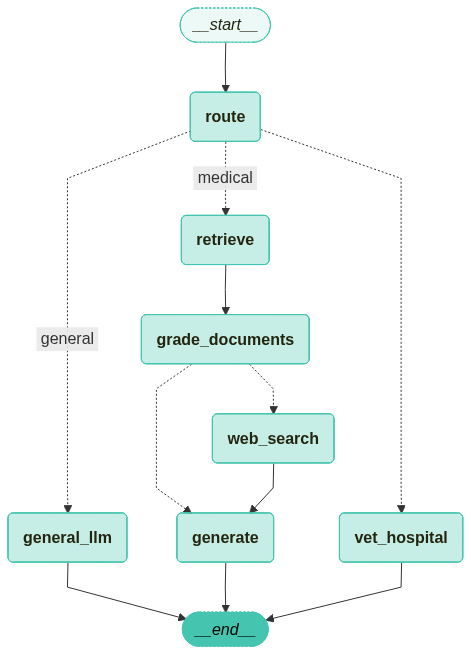

In [29]:
# 그래프 시각화
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


### 테스트

In [30]:
# 테스트 시나리오
test_cases = [
    {
        "question": "3개월 된 푸들이 계속 설사하고 밥을 안 먹어요. 무슨 문제일까요?"
    },
    {
         "question": "서울 강동구 천호동 근처에서 영업 중인 동물병원 2~3곳 추천해줘."
    },
    {
         "question": "강아지 손 훈련 시키려면 어떻게 해야해 ? "
    },
    {
         "question": "우리 강아지가 숨을 잘 못 쉬고 혀가 파래졌어요. 갑자기 이렇게 됐는데 어떻게 해야 하나요?"
    }
]

for i, test in enumerate(test_cases, 1):
    print(f"\n{'━' * 70}")
    print(f" 테스트 {i}: {test['question']}")
    print(f"{'━' * 70}")
    
    # 초기 상태
    initial_state = {
        "question": test["question"],
        "documents": [],
        "filtered_documents": [],
        "web_search_needed": "No",
        "context": "",
        "answer": "",
        "grade_results": [],
        "route" : ""
    }
    
    # 그래프 실행
    print("\n CRAG 워크플로우 실행 중...")
    
    final_state = None
    for output in app.stream(initial_state):
        for node_name, node_output in output.items():
            print(f"   노드 '{node_name}' 실행 완료")
        final_state = output
    
    answer = None

    '''''''''''''''''''''''''''''''''''''''''''''''''''
    답변
    '''''''''''''''''''''''''''''''''''''''''''''''''''

    if "generate" in final_state:
        answer = final_state["generate"]["answer"]
    elif "vet_hospital" in final_state:
        answer = final_state["vet_hospital"]["answer"]
    elif "general_llm" in final_state:
        answer = final_state["general_llm"]["answer"]
    elif "__end__" in final_state and "answer" in final_state["__end__"]:
        # LangGraph 버전에 따라 마지막에 __end__만 오는 경우 대비
        answer = final_state["__end__"]["answer"]

    if answer is None:
        answer = "답변을 생성할 수 없습니다."
    
    print(f"\n 최종 답변:\n{answer}")




━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 테스트 1: 3개월 된 푸들이 계속 설사하고 밥을 안 먹어요. 무슨 문제일까요?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

 CRAG 워크플로우 실행 중...

   [ROUTE] 라우팅 결과: medical
   노드 'route' 실행 완료
   노드 'retrieve' 실행 완료
   관련 문서 없음 → 웹 검색 필요!

   [DECISION] 다음 단계 결정 중...
관련 있는 문서가 없으므로, 웹 검색으로 이동합니다. 
   노드 'grade_documents' 실행 완료

   [WEB SEARCH 노드] 외부 웹 검색 수행 중...
   웹 검색 완료! 결과가 문서에 추가됨
   노드 'web_search' 실행 완료

   [GENERATE 노드] 답변 생성 중...
   답변 생성 완료!
   노드 'generate' 실행 완료

 최종 답변:
1) 요약: 3개월 된 푸들이 계속 설사를 하고 있으며, 식사도 하지 않고 있는 상태입니다. 이러한 증상은 심각한 문제를 나타낼 수 있습니다.

2) 가능한 원인들: 
   - **감염성 장염**: 세균이나 바이러스 감염으로 인해 설사가 발생할 수 있습니다. 특히 어린 강아지의 경우 파보 바이러스 감염이 심각한 설사를 유발할 수 있습니다.
   - **식이 문제**: 갑작스러운 사료 변경, 알레르기 반응, 또는 기름진 음식 섭취가 원인이 될 수 있습니다.
   - **기생충 감염**: 장내 기생충이 설사를 유발할 수 있습니다.
   - **소화기 질환**: 염증성 장 질환이나 췌장 문제 등도 고려해야 합니다.

3) 집에서 즉시 해볼 수 있는 안전한 관리 방법: 
   - 12시간 정도 금식 후, 소화가 잘 되는 처방식 사료나 부드러운 죽(예: 닭고기와 쌀)로 급여해 보세요.
   - 물은